In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:


df = pd.read_csv("london_weather_data_1979_to_2023.csv")
df2 = pd.read_csv("london_energy.csv")

In [3]:
avg_kwh = df2.groupby('Date')['KWH'].mean()
avg_kwh = pd.DataFrame({'date':avg_kwh.index.tolist(), 'consumption':avg_kwh.values.tolist()})
avg_kwh['date'] = pd.to_datetime(avg_kwh['date'])

In [4]:
# Step 2: Convert the weather data 'DATE' column to datetime
# Keep DATE column as datetime (do not convert to string)
df['date'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

In [5]:
merged_df = pd.merge(avg_kwh, df.drop(columns=['DATE']), on='date', how='inner')

In [6]:
print(merged_df.isna().any()[lambda x: x])

print(merged_df.info())

columns_to_fill = ['HU', 'CC']
merged_df[columns_to_fill] = merged_df[columns_to_fill].ffill()

print(merged_df.info())

HU    True
CC    True
dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         829 non-null    datetime64[ns]
 1   consumption  829 non-null    float64       
 2   TX           829 non-null    float64       
 3   Q_TX         829 non-null    int64         
 4   TN           829 non-null    float64       
 5   Q_TN         829 non-null    int64         
 6   TG           829 non-null    float64       
 7   Q_TG         829 non-null    int64         
 8   SS           829 non-null    float64       
 9   Q_SS         829 non-null    int64         
 10  SD           829 non-null    float64       
 11  Q_SD         829 non-null    int64         
 12  RR           829 non-null    float64       
 13  Q_RR         829 non-null    int64         
 14  QQ           829 non-null    float64       
 15  Q_QQ         829 non-nu

zsh:1: command not found: inline


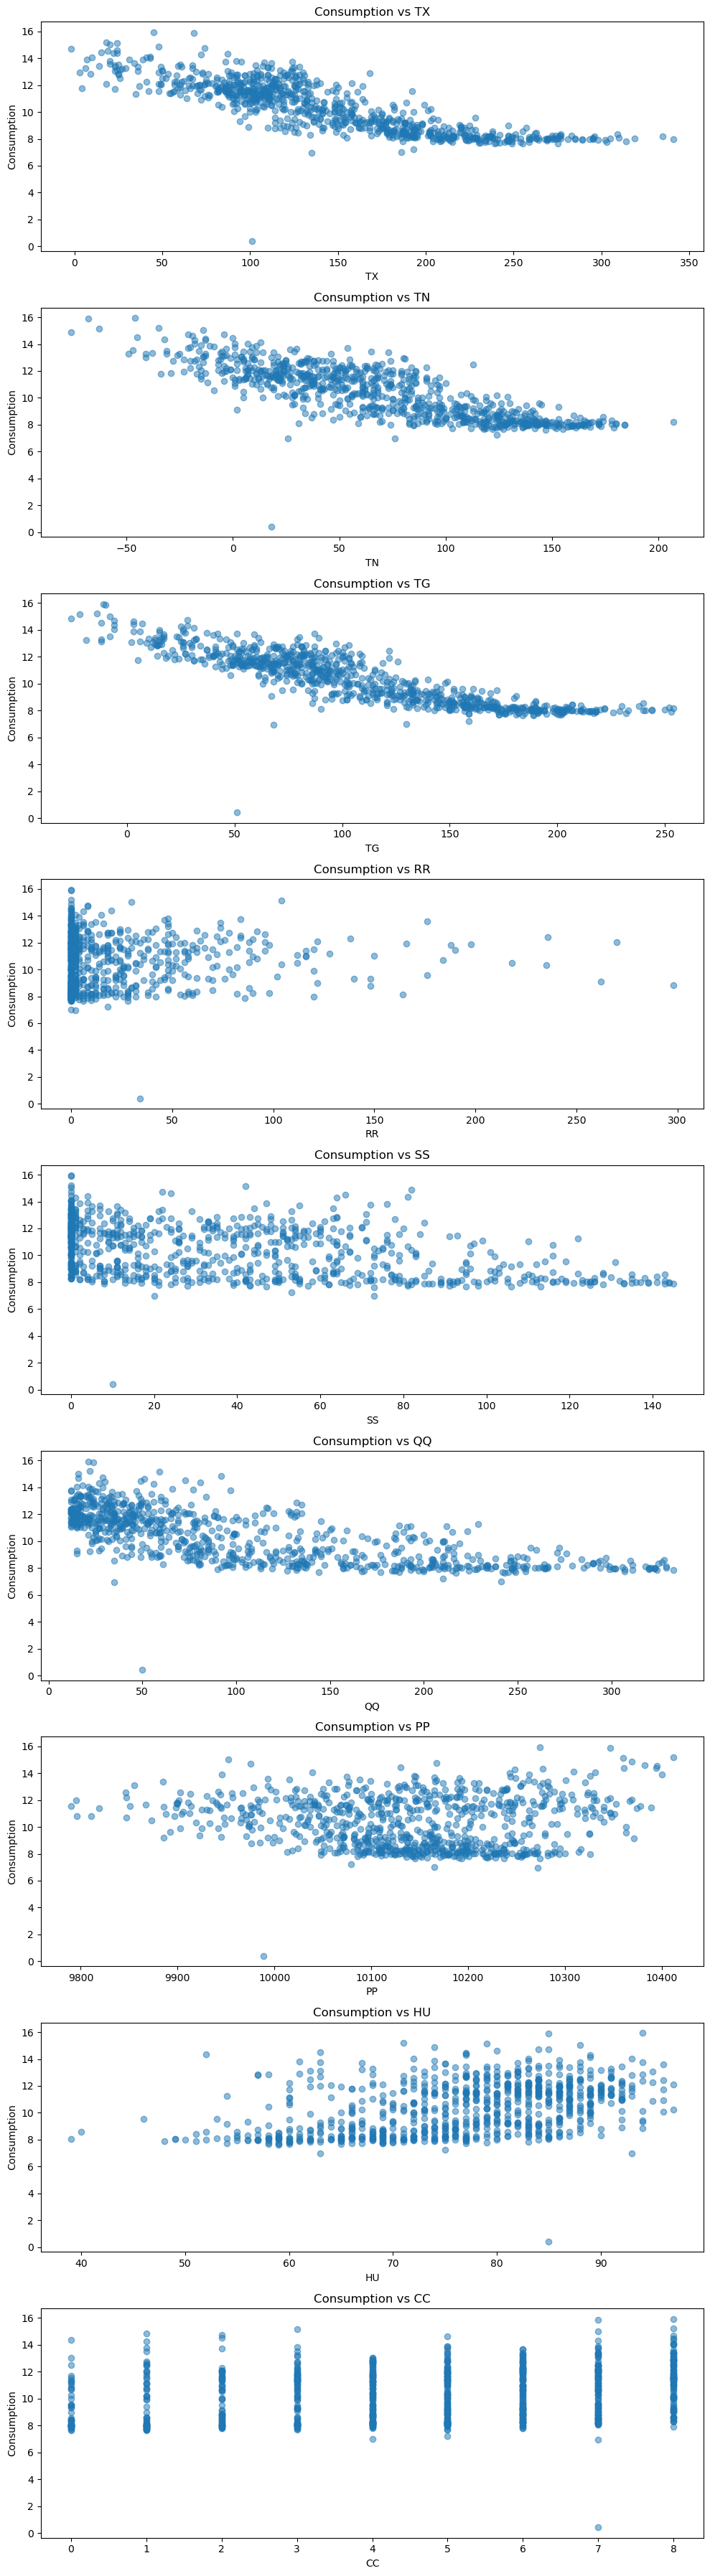

In [ ]:

valid_features_to_plot = ['TX', 'TN', 'TG', 'RR', 'SS', 'QQ', 'PP', 'HU', 'CC']

# Create subplots
fig, axes = plt.subplots(nrows=len(valid_features_to_plot), ncols=1, figsize=(10, 4 * len(valid_features_to_plot)))

for i, feature in enumerate(valid_features_to_plot):
    axes[i].scatter(merged_df[feature], merged_df['consumption'], alpha=0.5)
    axes[i].set_title(f'Consumption vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Consumption')

plt.tight_layout()
plt.show()